#### Importing Librarires 

In [116]:
import gym
import sys
import sys
import random

import torch
from torch.autograd import Function
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
from torch.distributions.categorical import Categorical
from sklearn.preprocessing import normalize

import math as mt
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
import qiskit_machine_learning
from qiskit_machine_learning.neural_networks import SamplerQNN, CircuitQNN
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [118]:
class HybridActorNetwork(nn.Module):
    def __init__(self, 
                 state_space, 
                 action_space,
                 number_of_qubits = 1,
                 number_of_shots = 1024):
        super(HybridActorNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.number_of_qubits = number_of_qubits
        self.number_of_shots = number_of_shots

        self.qubits = [i for i in range(0, self.number_of_qubits)]
        self.quantum_circuit = qiskit.QuantumCircuit(self.number_of_qubits)
        self.theta = qiskit.circuit.Parameter('theta')
        self.beta = qiskit.circuit.ParameterVector('beta', self.state_space)

        self.input_layer()
        self.parameterized_quantum_circuit()
        quantum_neural_network = EstimatorQNN(circuit = self.quantum_circuit, 
                                              input_params = self.beta.params, 
                                              weight_params = [self.theta], 
                                              input_gradients = True)
        self.quantum_layer = TorchConnector(quantum_neural_network)

        self.classical_layer_1 = nn.Linear(64, 128)
        self.classical_layer_2 = nn.Linear(128, 256)
        self.classical_layer_3 = nn.Linear(256, self.action_space)

    def input_layer(self):
        self.quantum_circuit.h(self.qubits)
        self.quantum_circuit.barrier()

        self.quantum_circuit.rz(self.beta[0], self.qubits)
        self.quantum_circuit.ry(self.beta[1], self.qubits)
        self.quantum_circuit.rz(self.beta[2], self.qubits)
        self.quantum_circuit.barrier()

    def parameterized_quantum_circuit(self):
        self.quantum_circuit.rx(self.theta, self.qubits)
        self.quantum_circuit.barrier()

    def forward(self, current_state):
        output_layer_1 = self.quantum_layer(current_state)
        output_layer_1 = output_layer_1.repeat(64)
        output_layer_2 = F.relu(self.classical_layer_1(output_layer_1))
        output_layer_3 = F.relu(self.classical_layer_2(output_layer_2))
        output_layer_4 = self.classical_layer_3(output_layer_3)
        
        policy = Categorical(F.softmax(output_layer_4, dim=-1))
        return policy

In [119]:
class HybridCriticNetwork(nn.Module):
    def __init__(self, 
                 state_space, 
                 action_space,
                 number_of_qubits = 1,
                 number_of_shots = 1024):
        super(HybridCriticNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.number_of_qubits = number_of_qubits
        self.number_of_shots = number_of_shots

        self.qubits = [i for i in range(0, self.number_of_qubits)]
        self.quantum_circuit = qiskit.QuantumCircuit(self.number_of_qubits)
        self.theta = qiskit.circuit.Parameter('theta')
        self.beta = qiskit.circuit.ParameterVector('beta', self.state_space)

        self.input_layer()
        self.parameterized_quantum_circuit()
        quantum_neural_network = EstimatorQNN(circuit = self.quantum_circuit, 
                                              input_params = self.beta.params, 
                                              weight_params = [self.theta], 
                                              input_gradients = True)
        self.quantum_layer = TorchConnector(quantum_neural_network)

        self.classical_layer_1 = nn.Linear(64, 128)
        self.classical_layer_2 = nn.Linear(128, 256)
        self.classical_layer_3 = nn.Linear(256, 1)

    def input_layer(self):
        self.quantum_circuit.h(self.qubits)
        self.quantum_circuit.barrier()

        self.quantum_circuit.rz(self.beta[0], self.qubits)
        self.quantum_circuit.ry(self.beta[1], self.qubits)
        self.quantum_circuit.rz(self.beta[2], self.qubits)
        self.quantum_circuit.barrier()

    def parameterized_quantum_circuit(self):
        self.quantum_circuit.rx(self.theta, self.qubits)
        self.quantum_circuit.barrier()

    def forward(self, current_state):
        output_layer_1 = self.quantum_layer(current_state)
        output_layer_1 = output_layer_1.repeat(64)
        output_layer_2 = F.relu(self.classical_layer_1(output_layer_1))
        output_layer_3 = F.relu(self.classical_layer_2(output_layer_2))
        state_value = self.classical_layer_3(output_layer_3)
    
        return state_value

In [123]:
class QERL_Agent():
    def __init__(self, 
                 Actor,
                 Critic,
                 max_time_steps,
                 actor_learning_rate,
                 critic_learning_rate,
                 discount_factor,
                 number_of_epochs):
        
        self.max_time_steps = max_time_steps
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.discount_factor = discount_factor
        self.number_of_epochs = number_of_epochs

        self.Actor = Actor
        self.Critic = Critic

        self.actor_optimizer = optim.Adam(self.Actor.parameters(), self.actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.Critic.parameters(), self.critic_learning_rate)

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.state_values = []
        self.policies = []
        self.done = []

    def replay_memory(self, 
                      state,
                      action,
                      state_value,
                      reward,
                      policy,
                      done):
        self.states.append(state)
        self.actions.append(action)
        self.policies.append(policy)
        self.state_values.append(state_value)
        self.rewards.append(torch.tensor([reward],
                                         dtype = torch.float,
                                         device = device))
        self.done.append(torch.tensor([1-done],
                                      dtype = torch.float,
                                      device = device))
        
    def action_selection(self, 
                         current_state):
        current_state = torch.FloatTensor(current_state).to(device)
        policy = self.Actor(current_state)
        action = policy.sample()
        policy = policy.probs[action]

        return action, policy
    
    def compute_discounted_rewards(self, 
                                   terminal_state):
        R = self.Critic(terminal_state)
        discounted_rewards = []
        for step in reversed(range(len(self.rewards))):
            R = self.rewards[step] + self.discount_factor * R * self.done[step]
            discounted_rewards.insert(0, R)
        return discounted_rewards
    
    def compute_actor_loss(self,
                           old_actor,
                           new_actor,
                           advantage):
        
        policy_ratio = new_actor.exp()/old_actor.exp()
        policy_distance_clipping = torch.clip(policy_ratio, 1 - 0.1, 1 + 0.1)

        actor_loss = -torch.min(advantage * policy_ratio,
                                advantage * policy_distance_clipping).mean()
        
        return actor_loss

    
    def ppo_loss(self, 
                 terminal_state, epoch):
        
        policies = [policy for policy in self.policies]
        policies = torch.reshape(torch.Tensor(policies) , (len(policies),1))
        discounted_rewards = self.compute_discounted_rewards(terminal_state)
        discounted_rewards = torch.cat(discounted_rewards)

        if epoch == 0:
            predicted_state_values = self.state_values

        else:
            predicted_state_values = [self.Critic(state) for state in self.states]

        predicted_state_values = torch.cat(predicted_state_values)

        predicted_policies = []
        for index, state in enumerate(self.states):
            policy = self.Actor(state)
            policy = policy.probs[self.actions[index]].unsqueeze(0)
            predicted_policies.append(policy)
        with torch.no_grad():
            advantage = discounted_rewards - predicted_state_values

        old_actor = policies
        new_actor = torch.cat(predicted_policies)

        actor_loss = self.compute_actor_loss(old_actor = old_actor,
                                             new_actor = new_actor,
                                             advantage = advantage)

        critic_loss = F.huber_loss(discounted_rewards, predicted_state_values)

        return actor_loss, critic_loss
    
    def training(self, terminal_state):

        for current_epoch in range(self.number_of_epochs):
            actor_loss, critic_loss = self.ppo_loss(terminal_state, epoch = current_epoch)

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            '''for name, param in self.Critic.named_parameters():
                if param.requires_grad:
                    print(param.data)

            print('Critic Pramaeters are printed')'''

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            

        return actor_loss.item(), critic_loss.item()

In [121]:
def data_transformation(state):
        return [mt.atan(i) for i in state] 

In [131]:
enviroment = gym.make("CartPole-v0").unwrapped

state_space = enviroment.observation_space.shape[0]-1
action_space = enviroment.action_space.n

actor_learning_rate = 0.01
critic_learning_rate = 0.1

max_time_steps = 50000
number_of_epochs = 5
number_of_episodes = 500
discount_factor = 0.99
constant_for_average = 10

Actor = HybridActorNetwork(state_space = state_space,
                           action_space = action_space)
Critic = HybridCriticNetwork(state_space = state_space,
                             action_space = action_space)
Agent = QERL_Agent(Actor = Actor,
                   Critic = Critic,
                   max_time_steps = max_time_steps,
                   discount_factor = discount_factor,
                   actor_learning_rate = actor_learning_rate,
                   critic_learning_rate = critic_learning_rate,
                   number_of_epochs = number_of_epochs)

score = []
actor_loss = []
critic_loss = []

average_score = []
average_actor_loss = []
average_critic_loss = []

for current_episode in range(0, number_of_episodes):
    Agent.clear_memory()
    (current_state, _ ) = enviroment.reset()
    episodic_score  = 0

    for time_step in range(0, max_time_steps):
        enviroment.render()
        current_state = data_transformation(state = current_state[1:4])
        action, policy = Agent.action_selection(current_state)
        current_state = torch.FloatTensor(current_state)
        state_value = Critic(current_state)

        next_state, reward, done, info, _ = enviroment.step(action.cpu().numpy())
        episodic_score += reward

        Agent.replay_memory(state = current_state,
                            action = action,
                            reward = reward,
                            policy = policy,
                            state_value = state_value,
                            done = done)
        
        current_state = next_state
        if done == True:
            break

    terminal_state = data_transformation(state = next_state[1:4])
    terminal_state = torch.FloatTensor(terminal_state).to(device)
    episodic_actor_loss, episodic_critic_loss = Agent.training(terminal_state = terminal_state)

    score.append(episodic_score)
    actor_loss.append(episodic_actor_loss)
    critic_loss.append(episodic_critic_loss)
    print('Episode:{} Score:{} Actor_Loss:{} Critic_Loss:{}'.format(current_episode, 
                                                                    episodic_score, 
                                                                    episodic_actor_loss, 
                                                                    episodic_critic_loss))
    
for i in range(0,int(len(score)/constant_for_average)):
    temp_score = sum(score[i * constant_for_average : (i+1) * constant_for_average])
    temp_actor_loss = sum(actor_loss[i * constant_for_average : (i+1) * constant_for_average])
    temp_critic_loss = sum(critic_loss[i * constant_for_average : (i+1) * constant_for_average])

    average_score.append(temp_score/10)
    average_actor_loss.append(temp_actor_loss/10)
    average_critic_loss.append(temp_critic_loss/10)

Episode:0 Score:23.0 Actor_Loss:-10.032330513000488 Critic_Loss:9.786489486694336
Episode:1 Score:15.0 Actor_Loss:-2.705646276473999 Critic_Loss:4.910424709320068
Episode:2 Score:20.0 Actor_Loss:-4.734506130218506 Critic_Loss:5.7793755531311035
Episode:3 Score:17.0 Actor_Loss:-8.05834674835205 Critic_Loss:8.130837440490723
Episode:4 Score:36.0 Actor_Loss:-7.993171691894531 Critic_Loss:8.733047485351562
Episode:5 Score:16.0 Actor_Loss:-5.566115856170654 Critic_Loss:5.155121326446533
Episode:6 Score:17.0 Actor_Loss:-2.4382874965667725 Critic_Loss:2.099170446395874
Episode:7 Score:47.0 Actor_Loss:-7.328120708465576 Critic_Loss:8.861847877502441
Episode:8 Score:14.0 Actor_Loss:0.3416355550289154 Critic_Loss:1.8510371446609497
Episode:9 Score:18.0 Actor_Loss:-1.8936599493026733 Critic_Loss:2.9545395374298096
Episode:10 Score:14.0 Actor_Loss:-1.3250972032546997 Critic_Loss:2.7823243141174316
Episode:11 Score:33.0 Actor_Loss:-0.6686241030693054 Critic_Loss:4.7846150398254395
Episode:12 Score:

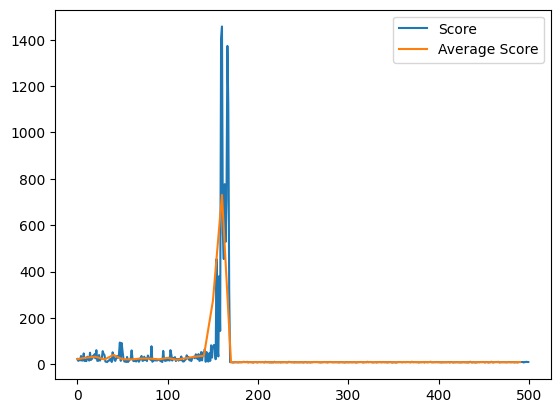

In [132]:
plt.plot(np.array(list(range(0, len(score)))), score, label='Score')
plt.plot(np.array(list(range(0, len(score), constant_for_average))), average_score, label='Average Score')
plt.legend()
plt.show()

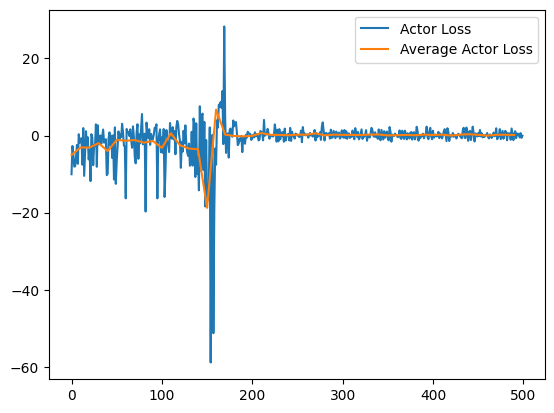

In [133]:
plt.plot(np.array(list(range(0, len(actor_loss)))), actor_loss, label='Actor Loss')
plt.plot(np.array(list(range(0, len(actor_loss), constant_for_average))), average_actor_loss, label='Average Actor Loss')
plt.legend()
plt.show()

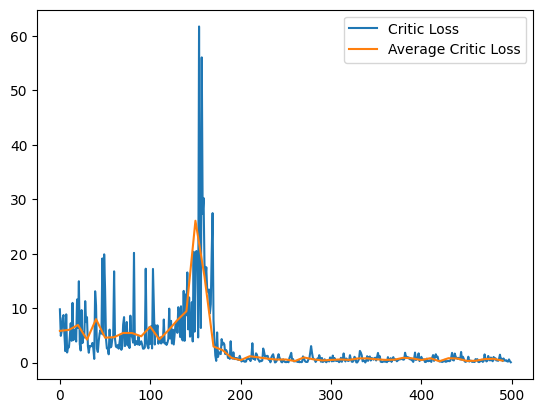

In [134]:
plt.plot(np.array(list(range(0, len(critic_loss)))), critic_loss, label='Critic Loss')
plt.plot(np.array(list(range(0, len(critic_loss), constant_for_average))), average_critic_loss, label='Average Critic Loss')
plt.legend()
plt.show()

In [ ]:
total_params = sum(p.numel() for p in Actor.parameters())
print(f"Number of parameters: {total_params}")

In [ ]:
total_params = sum(p.numel() for p in Critic.parameters())
print(f"Number of parameters: {total_params}")